In [67]:
import arff
import statistics
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import seaborn as sn
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from operator import attrgetter, itemgetter
from io import StringIO
from sklearn.model_selection import train_test_split
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, confusion_matrix,classification_report,precision_recall_fscore_support as score, average_precision_score
from sklearn import metrics
from sklearn.model_selection import cross_validate

from scipy.interpolate import UnivariateSpline, interp1d

import pickle

## training model
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [8]:
data = arff.load(open('../text-blob-pt/OffComBR3.arff'))
df = pd.DataFrame(data['data'])
df.columns = ['hate', 'sentence']

# transforming 'yes' into 1 and 'no' into 0
df['hate'] = df['hate'].apply(lambda x: 1 if x == 'yes' else 0)

X = df['sentence'].tolist()
y = df['hate'].tolist()
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.33, random_state=42)

pt_stop_words = nltk.corpus.stopwords.words('portuguese')

classifiers = []

In [9]:
max_df = 0.1
results_x = []
results_y = []

In [19]:
# Obs: Não rode! Resultados gravados abaixo. Processo longo.
while(max_df <= 1):
    aux = []
    for i in range(0,5):
        RandomForest =  Pipeline([
                ('tfidf',TfidfVectorizer(ngram_range=(1,4),
                                         lowercase=True,
                                         strip_accents='ascii',
                                         max_df=max_df
                                        )),
                ('clf', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0,)),
                ])
        MLP = Pipeline([
                ('tfidf',TfidfVectorizer(ngram_range=(1, 1),                                  
                                         lowercase=True,
                                         strip_accents='ascii',
                                         max_df=max_df)),
                ('clf', MLPClassifier(activation='logistic', alpha=0, solver='lbfgs')),
                ])
        SVCl = Pipeline([
                ('tfidf',TfidfVectorizer(ngram_range=(1, 1),                        
                                         lowercase=True,
                                         strip_accents='ascii',
                                         max_df=max_df)),
                ('clf', SVC(C=4, kernel='linear', probability=True, shrinking=True, tol=1)),
                ])
        classifiers.extend([('rdf',RandomForest), ('mlp', MLP), ('svc', SVCl)])

        for classifier in classifiers:
            classifier[1].fit(X_train, y_train)

        voting = VotingClassifier(estimators=classifiers[0:3], 
                                  voting='soft',
                                  weights=[1, 2, 1], 
                                  n_jobs=15)
        voting.fit(X_train, y_train)
        pred = voting.predict(X_test)
        report = classification_report(y_test, pred, output_dict=True)
        aux.append(report['1'])
        print(report['1'])
        
    results_y.append(aux)    
    results_x.append(max_df) 
    print(max_df)
    max_df = round(max_df + 0.1, 2)

{'precision': 0.5147058823529411, 'recall': 0.47297297297297297, 'f1-score': 0.4929577464788732, 'support': 74}
{'precision': 0.47368421052631576, 'recall': 0.4864864864864865, 'f1-score': 0.4799999999999999, 'support': 74}
{'precision': 0.53125, 'recall': 0.4594594594594595, 'f1-score': 0.4927536231884059, 'support': 74}
{'precision': 0.47435897435897434, 'recall': 0.5, 'f1-score': 0.4868421052631579, 'support': 74}
{'precision': 0.5166666666666667, 'recall': 0.4189189189189189, 'f1-score': 0.46268656716417905, 'support': 74}
1.0


In [21]:
results_y

[[{'precision': 0.4675324675324675,
   'recall': 0.4864864864864865,
   'f1-score': 0.4768211920529801,
   'support': 74},
  {'precision': 0.5223880597014925,
   'recall': 0.47297297297297297,
   'f1-score': 0.4964539007092198,
   'support': 74},
  {'precision': 0.5,
   'recall': 0.5135135135135135,
   'f1-score': 0.5066666666666666,
   'support': 74},
  {'precision': 0.47368421052631576,
   'recall': 0.4864864864864865,
   'f1-score': 0.4799999999999999,
   'support': 74},
  {'precision': 0.5396825396825397,
   'recall': 0.4594594594594595,
   'f1-score': 0.49635036496350365,
   'support': 74}],
 [{'precision': 0.4675324675324675,
   'recall': 0.4864864864864865,
   'f1-score': 0.4768211920529801,
   'support': 74},
  {'precision': 0.48717948717948717,
   'recall': 0.5135135135135135,
   'f1-score': 0.5,
   'support': 74},
  {'precision': 0.4457831325301205,
   'recall': 0.5,
   'f1-score': 0.4713375796178344,
   'support': 74},
  {'precision': 0.5076923076923077,
   'recall': 0.44594

In [22]:
# pickle_data = {'x': results_x, 'y': results_y}
# with open('max_df_results.sav', "wb") as f:
#    pickle.dump(pickle_data, f)

In [23]:
file_read = open('max_df_results.sav', 'rb')
a = pickle.load(file_read)

results_x = a['x']
results_y = a['y']

In [35]:
faverage_precision = []
faverage_recall = []
for i in results_y:
    average_precision = 0
    average_recall = 0
    for j in i:
        average_precision += j['precision']
        average_recall += j['recall']
    faverage_precision.append(average_precision/5)
    faverage_recall.append(average_recall/5)    

In [57]:
precision_stdev = []
recall_stdev = []
for i in results_y:
    precision_list = []
    recall_list = []
    for j in i:
        precision_list.append(j['precision'])
        recall_list.append(j['recall'])
    precision_stdev.append(statistics.stdev(precision_list))    
    recall_stdev.append(statistics.stdev(recall_list))

---------
---------
---------
---------
---------
---------
---------
---------
---------
---------


[Text(0, 0.5, 'Precision'),
 Text(0.5, 0, 'max_df'),
 Text(0.5, 1.0, 'max_df por precisão')]

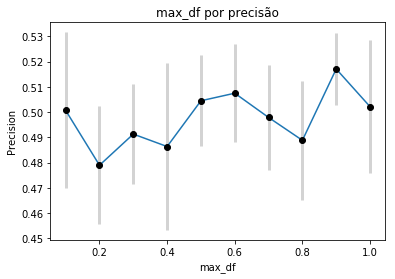

In [116]:
fig, ax = plt.subplots()
ax.plot(results_x, faverage_precision)
ax.errorbar(results_x, faverage_precision, yerr=precision_stdev, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

ax.set(xlabel='max_df', ylabel='Precision',
       title='max_df por precisão')



[Text(0, 0.5, 'Recall'),
 Text(0.5, 0, 'max_df'),
 Text(0.5, 1.0, 'max_df por recall')]

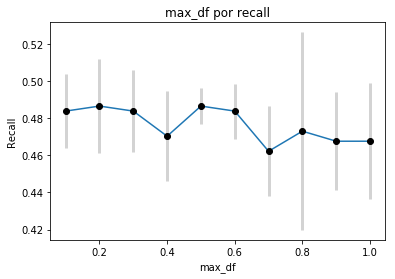

In [117]:
fig, ax = plt.subplots()

ax.plot(results_x, faverage_recall)
ax.errorbar(results_x, faverage_recall, yerr=recall_stdev, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

ax.set(xlabel='max_df', ylabel='Recall',
       title='max_df por recall')